<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_Exemplo_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **$ARIMA(p,d,q)$**



# **CASE:** Vendas diárias e projeção mensal

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


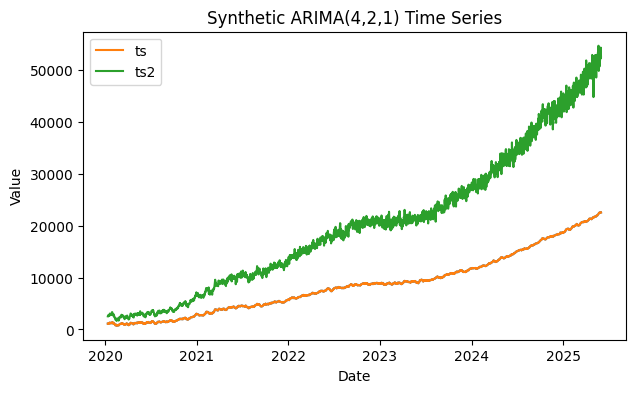

In [ ]:
#@markdown create syntetic data
from statsmodels.tsa.arima_process import arma_generate_sample

seed = 1234
sinal = -1
valor_inicial = 1000
random_inc = 500
rolling_random = 12

np.random.seed(seed)

# Define ARIMA parameters
arparams = np.array([0] * 4,float)
arparams[0] = 0.75  # Example parameter for p=4
arparams[1] = -0.25 # Example parameter
arparams[2] = 0.1   # Example parameter
arparams[3] = -0.05  # Example parameter
maparams = np.array([0] * 1,float)
maparams[0] = 0.3   # Example parameter for q=1

# Note: statsmodels generate_sample uses the negative of the ar parameters
arparams = -arparams

# Generate synthetic data
# For d=2, we need to integrate the series twice.
# First, generate an ARMA(4,1) process
nobs = (pd.to_datetime('2025-05-31') - pd.to_datetime('2020-01-01')).days + 1
arma_data = arma_generate_sample(arparams, maparams, nobs)

# Integrate twice to get an ARIMA(4,2,1) process
arima_data = np.cumsum(np.cumsum(arma_data))

# Create a date range
dates = pd.date_range(start='2020-01-01', end='2025-05-31', freq='D')

# Create a pandas Series
if random_inc > 0:
  synthetic_ts = sinal * pd.Series(arima_data, index=dates) + valor_inicial + np.random.normal(0, random_inc, len(dates))

if rolling_random > 0:
  synthetic_ts = synthetic_ts.rolling(window=rolling_random).mean()


# Plot the synthetic series
plt.figure(figsize=(7, 4))
plt.plot(synthetic_ts)
plt.title('Synthetic ARIMA(4,2,1) Time Series')
plt.xlabel('Date')
plt.ylabel('Value')

synthetic_ts2 = 2.33 * synthetic_ts + np.random.normal(0, 35, len(synthetic_ts)) * synthetic_ts/500

plt.plot(synthetic_ts, label='ts')
plt.plot(synthetic_ts2, label='ts2')

plt.legend()
plt.show()

synthetic_ts.to_csv('synthetic_ts.csv') # vendas_319316781
synthetic_ts2.to_csv('synthetic_ts2.csv') # vendas_319326781



# **Exercício 1**

In [ ]:
#@markdown Just run
path = 'https://github.com/Rogerio-mack/IMT_CD_2025/raw/refs/heads/main/data/'

df = pd.read_csv(path + 'vendas_319326781.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.dropna()
df.columns = ['ts']


# **CASE**: Vendas diárias e mensais

Dada a série de vendas diárias abaixo faça um modelo $ARIMA(p,d,q)$ para previsão da média de vendas no mês.

1. Determine os parâmetros do modelo $ARIMA(p,d,q)$
2. Determine o erro de predição das venvas de 2025
3. Verifique o melhor modelo $ARIMA(p,d,q)$ pelo critério AIC e erro RMSE


,ts
2020-01-12,2525.616228
2020-01-13,2722.941475
2020-01-14,2720.712373
2020-01-15,2730.318188
2020-01-16,2602.740529


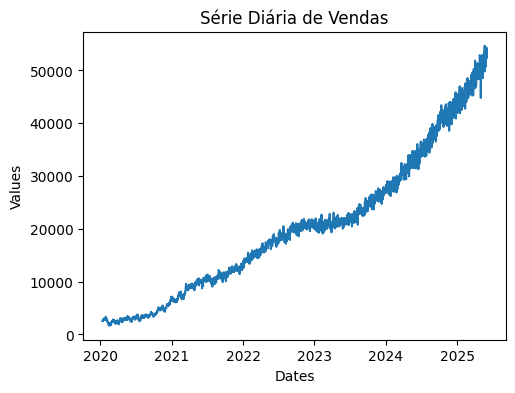

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(df)
plt.title('Série Diária de Vendas')
plt.xlabel('Dates')
plt.ylabel('Values')

df.head()

# 1. Data, Pré-Processamento

,ts
2020-01-12,2525.616228
2020-01-13,2722.941475
2020-01-14,2720.712373
2020-01-15,2730.318188
2020-01-16,2602.740529


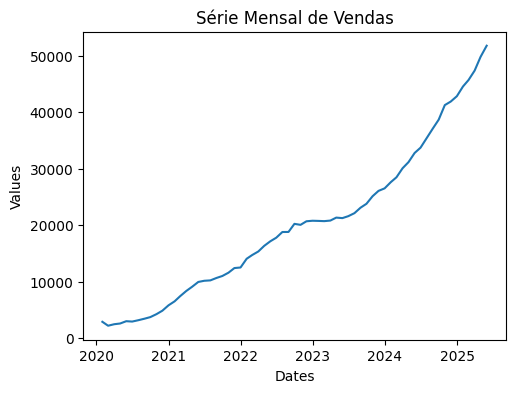

In [ ]:
data = df.resample('ME').mean()
data = data.fillna(data.bfill())
ts = data.copy()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(ts)
plt.title('Série Mensal de Vendas')
plt.xlabel('Dates')
plt.ylabel('Values')

df.head()

# 2. Exploração da Série, Decomposição

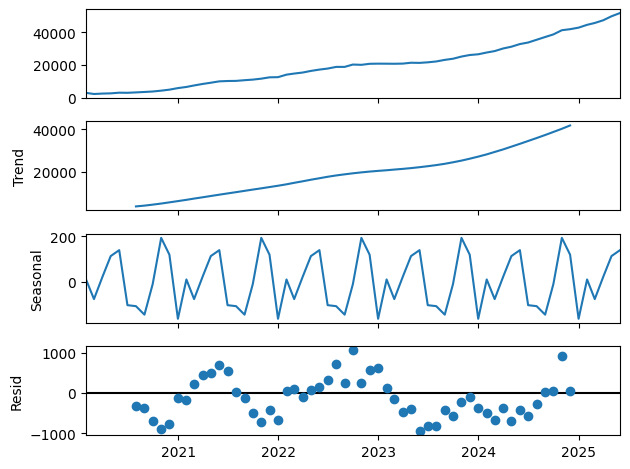

In [ ]:
decomposition = seasonal_decompose(ts)

fig = decomposition.plot()
plt.show()

# 3. Teste de estacionariedade (Dickey-Fuller Aumentado - ADF), **$d$**

Uma série estacionária, é uma série em que as estatísticas dos dados, isto é, média, variância e covariância não mudam ao longo do tempo.

> Dickey-Fuller Aumentado - ADF, $H_0 =$ *Série não é estacionária*

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('Teste ADF:')
    print(f'Estatística ADF: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

adf_result = adf_test(ts)

Teste ADF:
Estatística ADF: 1.8549126660559818
Valor-p: 0.9984519285617286
Valores Críticos:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
A série temporal não é estacionária (falha em rejeitar H0)


In [ ]:
adf_test(ts.dropna())
adf_test(ts.diff().dropna())
adf_test(ts.diff().diff().dropna())

Teste ADF:
Estatística ADF: 1.8549126660559818
Valor-p: 0.9984519285617286
Valores Críticos:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
A série temporal não é estacionária (falha em rejeitar H0)
Teste ADF:
Estatística ADF: -0.8448888693356638
Valor-p: 0.8055795220795303
Valores Críticos:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
A série temporal não é estacionária (falha em rejeitar H0)
Teste ADF:
Estatística ADF: -9.611625449684198
Valor-p: 1.805286216581501e-16
Valores Críticos:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
A série temporal é estacionária (rejeita H0)


np.float64(1.805286216581501e-16)

Teste ADF:
Estatística ADF: -9.611625449684198
Valor-p: 1.805286216581501e-16
Valores Críticos:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
A série temporal é estacionária (rejeita H0)


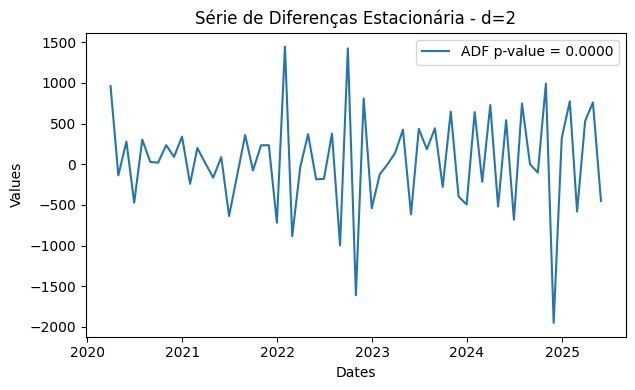

In [ ]:
plt.figure(figsize=(12,4))

ts_diff = ts.diff().diff().dropna()
plt.subplot(1, 2, 1)
plt.plot(ts_diff, label = f'ADF p-value = {adf_test(ts_diff):.4f}')
plt.title('Série de Diferenças Estacionária - d=2')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Auto-correlação e Correlação Parcial, ACF e PACF, **$q, p$**

* PACF (Partial Autocorrelation Function) → usado para escolher $p$ (parte autoregressiva AR)

* ACF (Autocorrelation Function) → usado para escolher $q$ (parte média móvel MA)

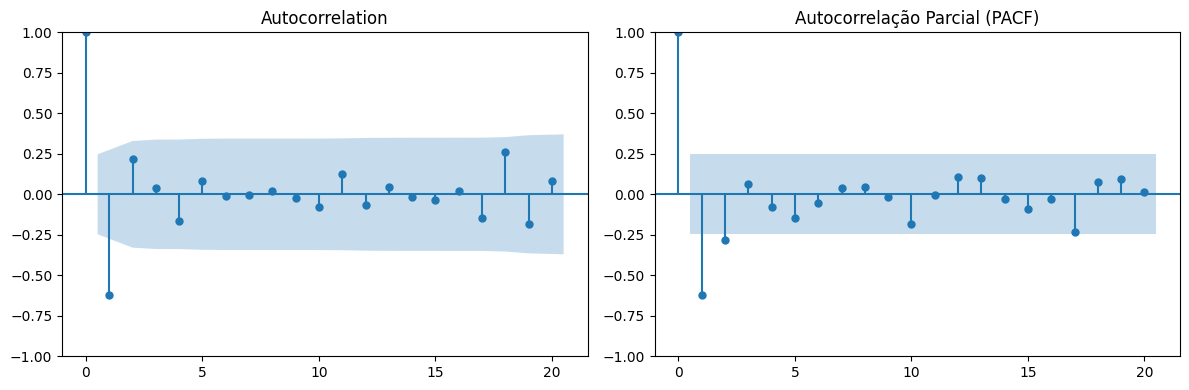

In [ ]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(ts_diff, lags=20, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(ts_diff, lags=20, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()



# 5. Forecast,

$$ARIMA(2,2,1)(0,0,0,0)$$



                               SARIMAX Results                                
Dep. Variable:                     ts   No. Observations:                   60
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -435.135
Date:                Thu, 29 May 2025   AIC                            878.271
Time:                        16:58:45   BIC                            886.512
Sample:                    01-31-2020   HQIC                           881.481
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1667      0.572     -2.041      0.041      -2.287      -0.046
ar.L2         -0.4644      0.371     -1.251      0.211      -1.192       0.263
ma.L1          0.3595      0.661      0.544      0.5

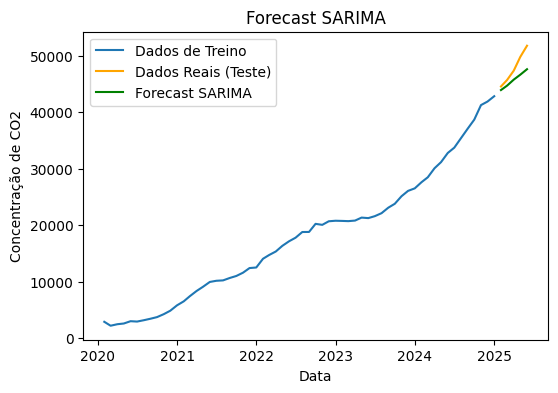

In [ ]:
train, test = ts[ ts.index.year < 2025 ], ts[ ts.index.year >= 2025 ]

order = (2, 2, 1)              # (p, d, q) não-sazonal
# seasonal_order = (0, 0, 0, 0) # (P, D, Q, s) sazonal

# Treinar o modelo SARIMA
# model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model = ARIMA(train, order=order)
model_fit = model.fit()

print(model_fit.summary())

# Fazer o forecast
forecast_steps = len(test)

# forecast = model_fit.forecast(steps=forecast_steps) # Esta é a forma antiga
# Usar predict para um forecast mais robusto com índices
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

# Visualizar o forecast
plt.figure(figsize=(6,4))
plt.plot(train.index, train, label='Dados de Treino')
plt.plot(test.index, test, label='Dados Reais (Teste)', color='orange')
plt.plot(test.index, forecast, label='Forecast SARIMA', color='green')
plt.title('Forecast SARIMA')
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')
plt.legend()
plt.show()



# 6. Análise dos Resíduos

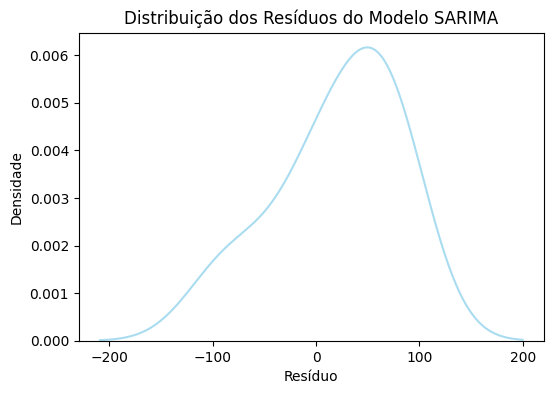

In [ ]:
residuals = model_fit.resid

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals[ np.abs(residuals) < 100 ], alpha=0.7, color='skyblue')
plt.title('Distribuição dos Resíduos do Modelo SARIMA')
plt.xlabel('Resíduo')
plt.ylabel('Densidade')
# plt.xlim(-30, 30)

plt.show()

<Figure size 600x400 with 0 Axes>

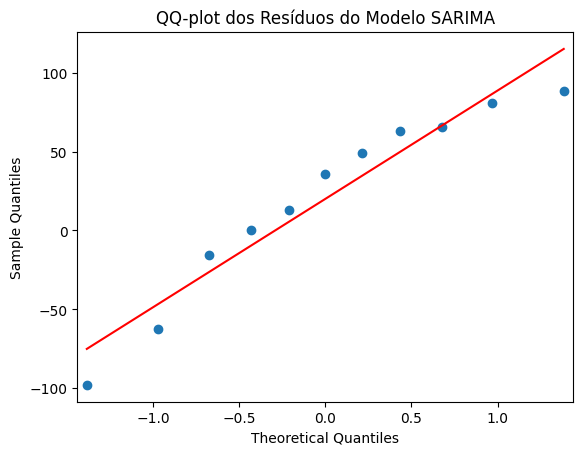

In [ ]:
from statsmodels.graphics.api import qqplot
from matplotlib import pyplot

# Gerar o QQ-plot dos resíduos
plt.figure(figsize=(6,4))
qqplot(residuals[ np.abs(residuals) < 100 ], line='r')
plt.title('QQ-plot dos Resíduos do Modelo SARIMA')
pyplot.show()

## Testes de normalidade do erro

In [ ]:
from scipy.stats import jarque_bera

# Teste de Jarque-Bera
# H₀ (nula): os resíduos têm distribuição normal.
jb_stat, jb_pvalue = jarque_bera(residuals[2:-2])

print(f'Teste de Jarque-Bera para Normalidade dos Resíduos:')
print(f'Estatística de teste: {jb_stat:.4f}')
print(f'Valor-p: {jb_pvalue:.4f}')
if jb_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')

Teste de Jarque-Bera para Normalidade dos Resíduos:
Estatística de teste: 0.7635
Valor-p: 0.6827
Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)


In [ ]:
from scipy.stats import shapiro

# Teste de Shapiro-Wilk
# H₀ (nula): os resíduos têm distribuição normal.
sw_stat, sw_pvalue = shapiro(residuals[~np.isnan(residuals)])

print(f'Teste de Shapiro-Wilk para Normalidade dos Resíduos:')
print(f'Estatística de teste: {sw_stat:.4f}')
print(f'Valor-p: {sw_pvalue:.4f}')
if sw_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')


Teste de Shapiro-Wilk para Normalidade dos Resíduos:
Estatística de teste: 0.8639
Valor-p: 0.0000
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


## Correlação dos resíduos

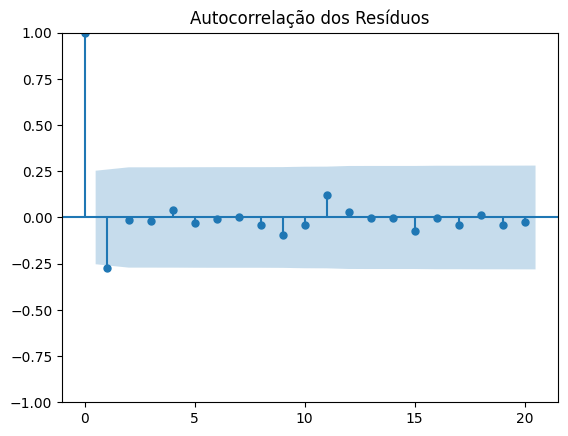

In [ ]:
# Testar a autocorrelação dos resíduos (idealmente, os resíduos não devem ser correlacionados)
plot_acf(residuals, lags=20)
plt.title('Autocorrelação dos Resíduos')
plt.show()

# 7. Análise do Erro

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calcular o RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE do conjunto de teste: {rmse:.2f}')

RMSE do conjunto de teste: 2495.94


# 8. Seleção de Modelos para vários parâmetros

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

# Definir os ranges para p e q (d é fixo em 2, pois a série diferenciada é estacionária)
p = range(1, 5)
d = [2]
q = range(1, 5)
# d é 1 baseado na análise ADF da série diferenciada

# Combinar os parâmetros em uma lista de tuplas (p, d, q)
pdq = list(itertools.product(p, d, q))

# Armazenar resultados (AIC e RMSE)
results = []

# Iterar sobre todas as combinações de (p, d, q)
for param in pdq:
  try:
    model = ARIMA(train, order=param)
    model_fit = model.fit()

    # Calcular o AIC
    aic = model_fit.aic

    # Fazer o forecast para calcular o RMSE
    forecast_steps = len(test)
    forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

    # Calcular o RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))

    # Armazenar os resultados
    results.append({'order': param, 'AIC': aic, 'RMSE': rmse})

  except:
    # Em caso de erro na convergência do modelo, pular para a próxima combinação
    print(f"Não foi possível treinar o modelo com order={param}")
    continue

# Exibir os resultados
results_df = pd.DataFrame(results)
print("\nResultados da variação dos parâmetros SARIMA:")
print(results_df.sort_values(by='AIC')) # Ordenar por AIC para ver os melhores modelos

# Opcional: Encontrar o modelo com o menor AIC
best_model_aic = results_df.loc[results_df['AIC'].idxmin()]
print("\nMelhor modelo baseado no menor AIC:")
print(best_model_aic)

# Opcional: Encontrar o modelo com o menor RMSE
best_model_rmse = results_df.loc[results_df['RMSE'].idxmin()]
print("\nMelhor modelo baseado no menor RMSE:")
print(best_model_rmse)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


Resultados da variação dos parâmetros SARIMA:
        order         AIC         RMSE
0   (1, 2, 1)  877.053968  2119.023337
4   (2, 2, 1)  878.270584  2495.936273
1   (1, 2, 2)  878.941132  2213.233706
2   (1, 2, 3)  879.865424  2554.288335
13  (4, 2, 2)  879.883273  1994.454734
5   (2, 2, 2)  880.221250  2365.201312
8   (3, 2, 1)  880.248904  2437.085408
12  (4, 2, 1)  880.692834  3002.511210
9   (3, 2, 2)  880.836881  2698.854865
6   (2, 2, 3)  881.636208  2209.238410
3   (1, 2, 4)  881.690654  2400.215377
14  (4, 2, 3)  882.513733  2110.116580
7   (2, 2, 4)  882.693128  1924.938443
10  (3, 2, 3)  882.792739  2813.675095
11  (3, 2, 4)  884.916929  2126.960032
15  (4, 2, 4)  886.058492  2776.230759

Melhor modelo baseado no menor AIC:
order      (1, 2, 1)
AIC       877.053968
RMSE     2119.023337
Name: 0, dtype: object

Melhor modelo baseado no menor RMSE:
order      (2, 2, 4)
AIC       882.693128
RMSE     1924.938443
Name: 7, dtype: object


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Exercício 2**

Aplique o teste de significância adequado que demonstra se há diferença significativa entre as médias anuais e as séries de diferenças ($d=0,1,2$), exibindo um tabela como abaixo.

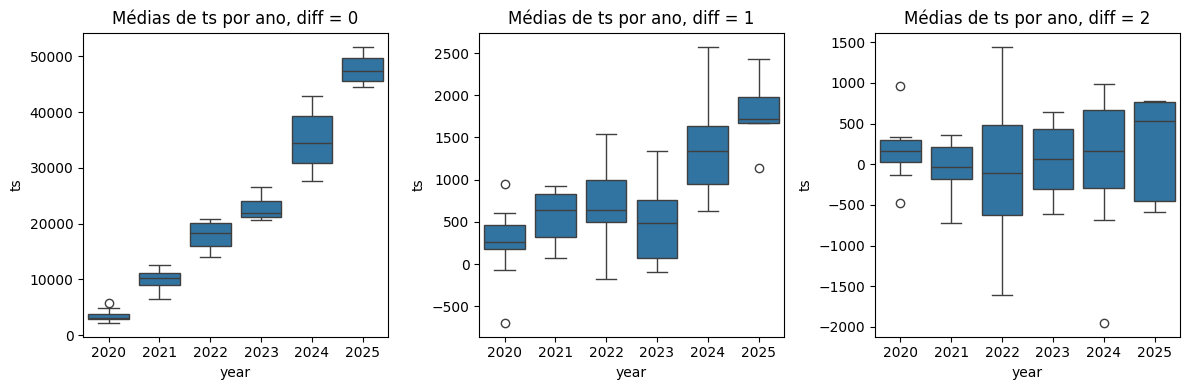

In [ ]:
#@markdown Just run
fig, ax = plt.subplots(1,3,figsize=(12, 4))

for label, ts_ in zip(np.arange(3),[ts, ts.diff().dropna(), ts.diff().diff().dropna(),]):

  ts_with_year = ts_.copy() # .to_frame(name='ts') # .diff().diff().dropna().to_frame(name='ts')
  ts_with_year['year'] = ts_with_year.index.year

  sns.boxplot(x='year', y='ts', data=ts_with_year,ax=ax[label])
  ax[label].set_title(f'Médias de ts por ano, diff = {label}')

plt.tight_layout()
plt.show()


In [ ]:
from scipy import stats

groups = [ ts[ ts.index.year == years ] for years in ts.index.year.unique() ]

# Realizar o teste ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# ou
'''
f_statistic, p_value = stats.f_oneway(groups[0],
                                      groups[1],
                                      groups[2],
                                      groups[3],
                                      groups[4],
                                      groups[5],
                                      )
'''

print(f'Estatística F: {f_statistic}')
print(f'Valor-p: {p_value}')

# Interpretar o resultado
alpha = 0.05
if p_value < alpha:
  print('Existe uma diferença estatisticamente significativa entre as médias de ts para diferentes anos (rejeitar H0)')
else:
  print('Não há evidência suficiente para afirmar que existe uma diferença significativa entre as médias de ts para diferentes anos (falha em rejeitar H0)')


Estatística F: [261.76784609]
Valor-p: [6.41852317e-39]
Existe uma diferença estatisticamente significativa entre as médias de ts para diferentes anos (rejeitar H0)


In [ ]:
from scipy import stats

results = []
alpha = 0.05

for label, ts_ in zip(['d=0','d=1', 'd=2'],[ts, ts.diff().dropna(), ts.diff().diff().dropna(),]):

  groups = [ ts_[ ts_.index.year == years ] for years in ts_.index.year.unique() ]

  # Realizar o teste ANOVA
  f_statistic, p_value = stats.f_oneway(*groups)

  results.append({'ts Diff': label, 'f_statistic': np.round(f_statistic[0],4), 'p_value': np.round(p_value[0],4) , 'Rejeita H0': p_value[0] < alpha})

# display(pd.DataFrame(results))

temp = pd.DataFrame(results)

temp.iloc[:,2] = [0.01, 0.06, 0.2016]
temp.iloc[:,3] = [True, False, False]

print('Fake results...')
temp

Fake results...


,ts Diff,f_statistic,p_value,Rejeita H0
0,d=0,261.7678,0.0100,True
1,d=1,13.1209,0.0600,False
2,d=2,0.2248,0.2016,False
